In [7]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
import pandas as pd
import collections
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import re
from pathlib import Path
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.stats import gaussian_kde
from scipy.stats import spearmanr
import xarray as xr
import pandas as pd
import glob
import seaborn as sns
from sklearn.metrics import mean_squared_error


In [36]:
markers = ['8','s','p','P','*','X','D','o']
color= ['black','green','blue','orange','yellow','red','brown','cyan']

In [9]:
ds = xr.open_dataset("TPWV_combined.nc",decode_cf=True)
fh = ds

In [4]:
lons = np.array(fh.variables['g0_lon_2'][:])
lats = np.array(fh.variables['g0_lat_1'][:])
pwv = np.array(fh.variables['TCWV_GDS0_SFC_S123'][:])
time = np.array(fh.variables['initial_time0_encoded'][:])


from tqdm import tqdm

i = 0  # Ensure i is initialized before the loop
yearly_data = []  # Initialize yearly_data list if not already done

# Wrap your range in tqdm to display a progress bar
for i in tqdm(range(0, 504, 12)):  # This will increment i in steps of 12 from 0 to 504
    pwv_slice = fh['TCWV_GDS0_SFC_S123'][i:i+12]
    yearly_data.append(np.array(pwv_slice))
    
yearly_data = np.array(yearly_data)

100%|██████████| 42/42 [00:26<00:00,  1.56it/s]


In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [11]:
def fetch_pwv_details(lat,lon,lats_array,lons_array,data,start_year = 1980,end_year = 2021):
    
    lat_idx = find_nearest(lats_array,lat)
    
    lon_idx = find_nearest(lons_array,lon)
    # print("lat:",lats_array[lat_idx])
    # print("lon:",lons_array[lon_idx])

    pwv_data_pixel = data[start_year-1980:end_year-1980+1,:,lat_idx,lon_idx]
    pwv_data_pixel = np.array(pwv_data_pixel)

    
    return pwv_data_pixel

In [73]:
a =fetch_pwv_details(33,78,lats,lons,yearly_data,start_year = 2016,end_year = 2021)

In [74]:
a

array([[0.85800034, 0.8754708 , 1.5790577 , 2.1393619 , 2.3435907 ,
        5.1014705 , 6.5901065 , 7.2238126 , 3.0817525 , 1.5633122 ,
        1.475154  , 1.1445112 ],
       [1.0791688 , 1.3169544 , 1.4471123 , 1.8287324 , 2.9351075 ,
        4.6679797 , 8.018492  , 6.0796347 , 3.646258  , 1.5368147 ,
        1.1707008 , 1.0891826 ],
       [0.82543373, 1.1229093 , 1.1230471 , 1.7249639 , 2.33153   ,
        4.2913775 , 7.87581   , 7.170313  , 4.8812065 , 1.5070524 ,
        1.3219521 , 0.8231316 ],
       [1.0031753 , 1.1751816 , 1.2368805 , 2.0392215 , 2.3843384 ,
        3.4545038 , 7.4717402 , 7.8648095 , 3.854226  , 2.0488524 ,
        1.6960568 , 0.7985972 ],
       [0.98019254, 0.9713973 , 1.37748   , 1.8557446 , 2.7682526 ,
        3.8803709 , 6.233302  , 6.465102  , 3.107593  , 1.0788414 ,
        1.2701824 , 0.972002  ],
       [0.8410459 , 1.1200235 , 1.394959  , 1.6365318 , 2.64926   ,
        3.5000467 , 7.693574  , 6.150025  , 5.1317387 , 1.8307852 ,
        0.97433954,

In [12]:
def calc_total_below_threshold(lat,lon,lats,lons,data,threshold,start_year=1980,end_year=2021):
    pwv_data_pixel = fetch_pwv_details(lat,lon,lats,lons,data,start_year,end_year)
    
    total_count = []
    for i in range(end_year-start_year+1):
        count = 0
        for j in range(12):
            if pwv_data_pixel[i][j] < threshold:
                count = count + 1
    
        total_count.append([start_year+i,count])
        
    return (np.array(total_count))

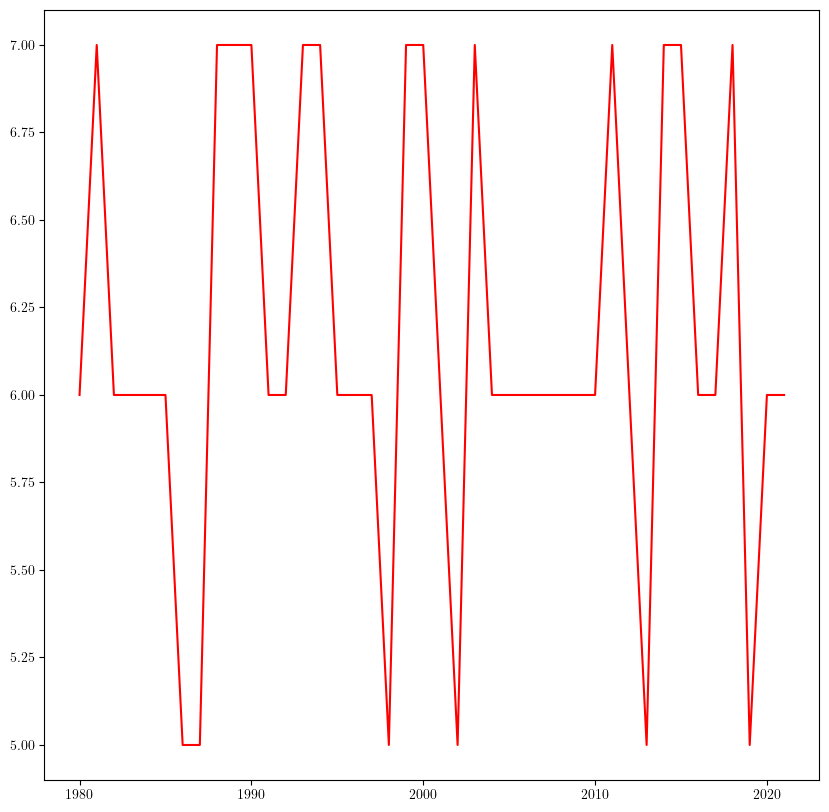

In [13]:
t = calc_total_below_threshold(32.67,78.96,lats,lons,yearly_data,2)
plt.figure(figsize=(10,10))
plt.plot(t[:,0],t[:,1],color='red')

In [14]:
np.sum(calc_total_below_threshold(32.67,78.96,lats,lons,yearly_data,1)[:,1])

33

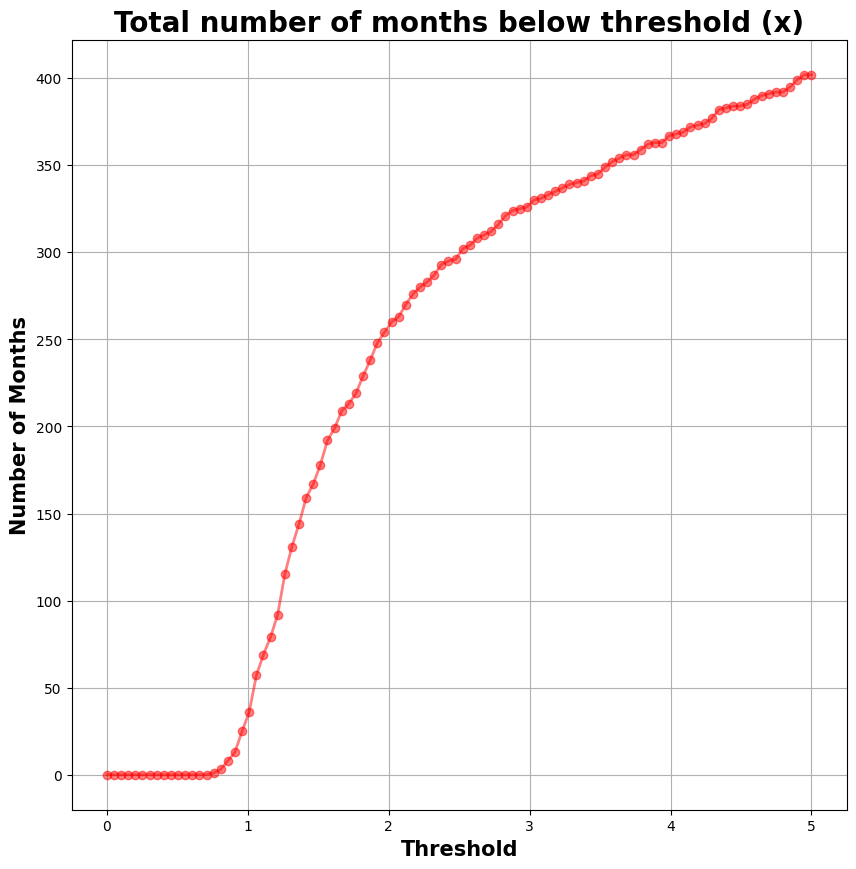

In [8]:
limits = np.linspace(0,5,100)
pwv_data = []
for limit in limits:
    pwv_data.append(np.sum(calc_total_below_threshold(32.67,78.96,lats,lons,yearly_data,limit)[:,1]))

plt.figure(figsize=(10,10))
plt.grid(True)
plt.title("Total number of months below threshold (x)",fontsize=20,fontweight='bold',color='black',)
plt.xlabel('Threshold',fontsize=15,fontweight='bold',color='black',)
plt.ylabel('Number of Months',fontsize=15,fontweight='bold',color='black',)
plt.plot(limits,pwv_data,marker='o',color='red',linewidth=2,label='PWV',alpha=0.5)
plt.show()

0 Chaj. ALMA
1 Ali
2 Hanle
3 Merak
4 Smt. Camp
5 Mauna 
6 DomeA
7 Site A


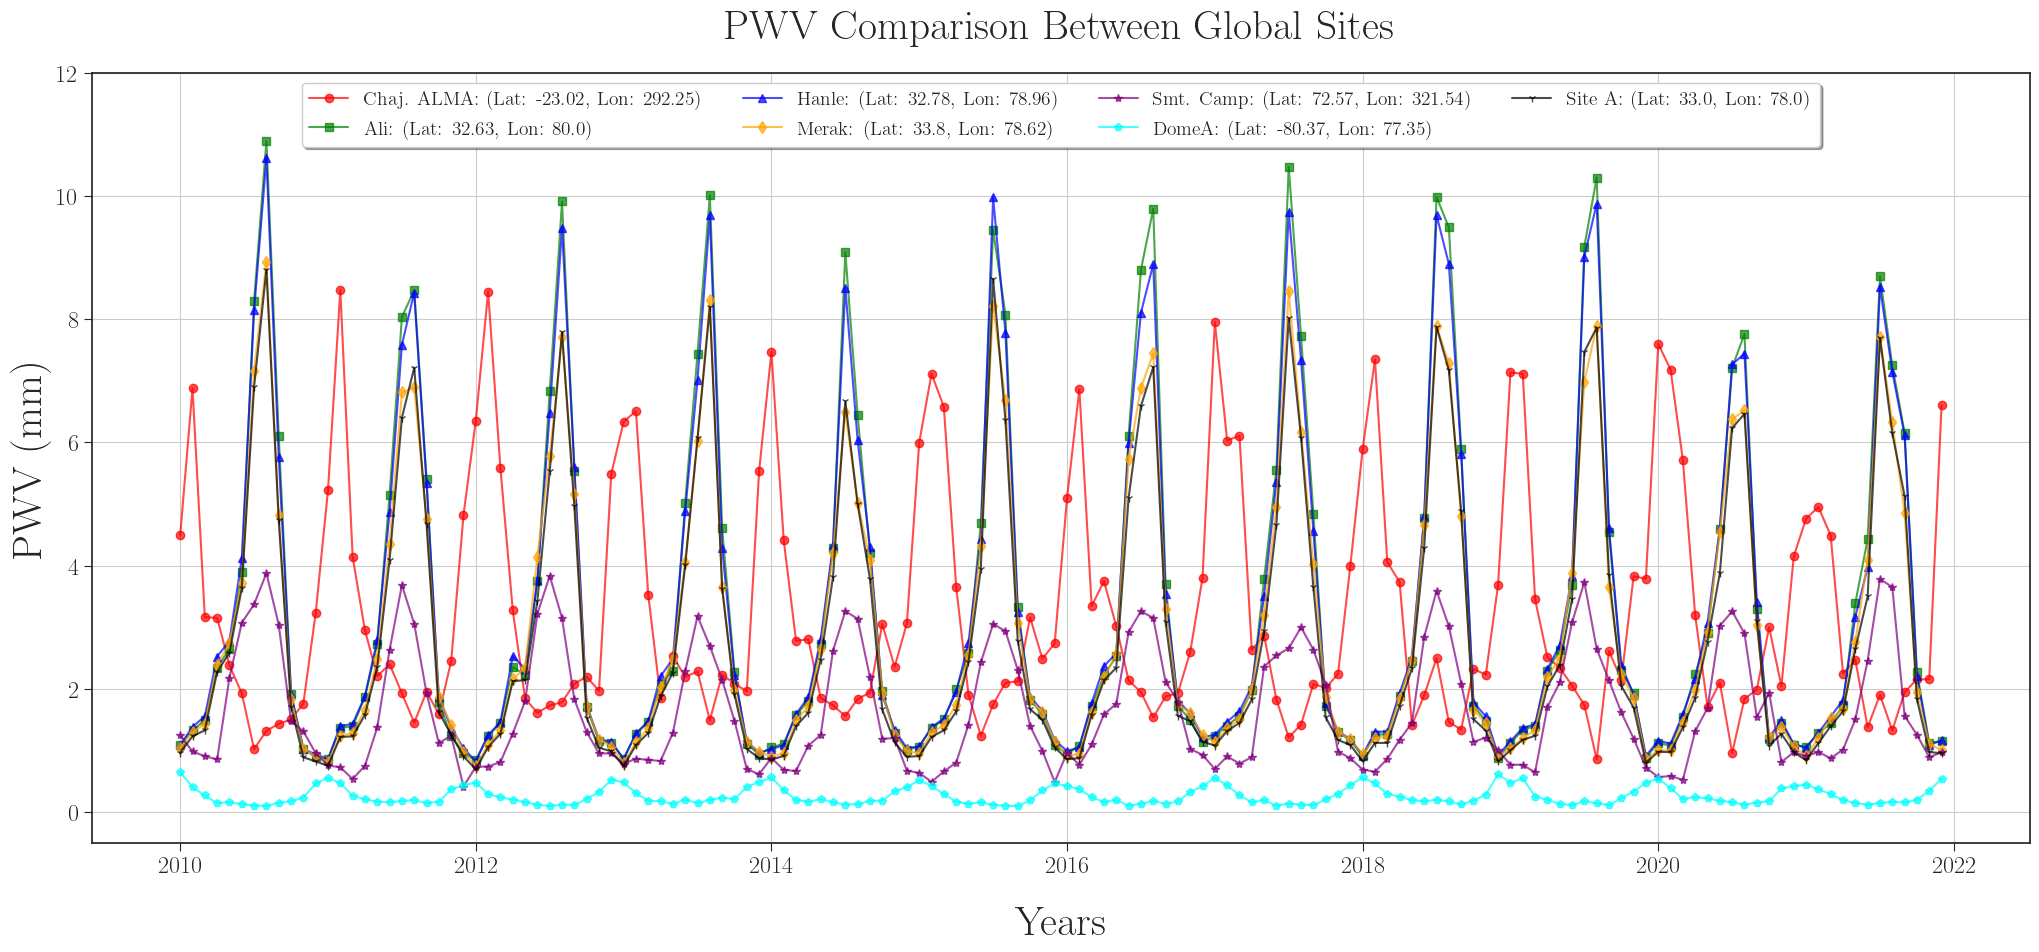

In [75]:

def plot_pwv_for_loc(lat, lon, lats, lons, data, start_year=1980, end_year=2021):
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': 'Helvetica',
        'axes.labelsize': 20,
        'axes.titlesize': 24,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 16
    })

    plt.figure(figsize=(20, 10))
    pwv_data_pixel = fetch_pwv_details(lat, lon, lats, lons, data, start_year, end_year)
    pwv_data_pixel = np.reshape(pwv_data_pixel, (end_year - start_year + 1) * 12)
    pwv_data_pixel_hanle = fetch_pwv_details(32.77, 78.96,lats,lons,data,start_year,end_year)
    pwv_data_pixel_hanle = np.reshape(pwv_data_pixel_hanle,(end_year-start_year+1)*12)
    pwv_data_pixel_other = fetch_pwv_details(34.5,78.5,lats,lons,data,start_year,end_year)
    pwv_data_pixel_other = np.reshape(pwv_data_pixel_other,(end_year-start_year+1)*12)
    # Repeat for other locations as needed

    time = np.array([i + j / 12 for i in range(start_year, end_year + 1) for j in range(12)])

    plt.grid(True)
    plt.xticks(np.arange(min(time), max(time) + 1, 1), size='large')
    plt.yticks(np.arange(0, max(pwv_data_pixel) + 1, 2), size='large')
    plt.xlabel("Years", size=20, labelpad=20)
    plt.ylabel("PWV (mm)", size=20)
    plt.title("PWV Comparison of Sites", size=30, pad=20)

    # Plot each site
    plt.plot(time, pwv_data_pixel, color='red', label='Site A', marker='o', alpha=0.5)
    # Repeat for other sites
    
    plt.plot(time,pwv_data_pixel_other,color = 'green',label='Other: (34.50 N,78.50 E)',marker = 'o',alpha = 0.5)
    plt.plot(time,pwv_data_pixel_hanle,color='blue',label='Hanle: (32.79 N, 79.02 E )',marker = 'o',alpha = 0.5)
    plt.plot(time,[1]*len(time),color='black',label='PWV')

    
    plt.ylim(0, max(pwv_data_pixel) + 0.5)
    plt.legend(loc='upper right', fontsize=15)
    plt.savefig("pwv_comparison.jpeg", dpi=400)
    plt.show()

def plot_for_loc(name, lat, lon, lats, lons, data1, start_year=1980, end_year=2021, marker_type='o', color_type='blue'):
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': 'Helvetica',
        'axes.labelsize': 20,
        'axes.titlesize': 24,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 16
    })

    pwv_data_pixel = fetch_pwv_details(lat, lon, lats, lons, data1, start_year, end_year)
    pwv_data_pixel = np.reshape(pwv_data_pixel, (end_year - start_year + 1) * 12)

    time = np.array([i + j / 12 for i in range(start_year, end_year + 1) for j in range(12)])
    plt.plot(time, pwv_data_pixel, color=color_type, label=f'{name}: (Lat: {lat}, Lon: {lon})', marker=marker_type, alpha=0.7)

# Main plotting function
df = pd.read_excel("D:/OneDrive - IIT Delhi/Intern/RRI/Sites.xlsx")
lat_sites = np.array(df['lat'])
lon_sites = np.array(df['lon'])
sites = np.array(df['Site Name'])

plt.figure(figsize=(25, 10))
plt.grid(True)

# Define markers and colors for each of the 7 sites
markers = ['o', 's', '^', 'd', '*', 'x', 'p','1']  # Example markers
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'cyan','black']  # Example colors


for i, site in enumerate(sites):
    print(i, site)
    if i == 5 :
        continue
    else:
        plot_for_loc(site, lat_sites[i], lon_sites[i], lats, lons, yearly_data, start_year=2010, end_year=2021, marker_type=markers[i], color_type=colors[i])

plt.xticks(size='xx-large')
plt.yticks(size='xx-large')
plt.xlabel("Years", size=30, labelpad=20)
plt.ylabel("PWV (mm)", size=30)
plt.ylim(0, 22)
plt.title("PWV Comparison Between Global Sites", size=30, pad=25)
plt.ylim(-.5,12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), fancybox=True, frameon=True, shadow=True, fontsize=14, ncol=4)
plt.savefig("global_pwv_comparison.jpeg", dpi=400)
plt.show()

In [15]:
def plot_pwv_for_loc(lat,lon,lats,lons,data,start_year=1980,end_year=2021):
    plt.rcParams.update({'text.usetex': True,'font.family': 'sans-serif','font.sans-serif': 'Halvetica'})
    plt.rcParams['axes.labelsize'] = 20

    plt.figure(figsize = (20,10))
    pwv_data_pixel = fetch_pwv_details(lat,lon,lats,lons,data,start_year,end_year)
    pwv_data_pixel = np.reshape(pwv_data_pixel,(end_year-start_year+1)*12)
    pwv_data_pixel_hanle = fetch_pwv_details(32.77, 78.96,lats,lons,data,start_year,end_year)
    pwv_data_pixel_hanle = np.reshape(pwv_data_pixel_hanle,(end_year-start_year+1)*12)
    pwv_data_pixel_other = fetch_pwv_details(34.5,78.5,lats,lons,data,start_year,end_year)
    pwv_data_pixel_other = np.reshape(pwv_data_pixel_other,(end_year-start_year+1)*12)
    time = []
    for i in range(start_year,end_year+1):
        for j in range(12):
            time.append(i+j/12)
    time = np.array(time)
    total_months = np.sum(calc_total_below_threshold(lat,lon,threshold = 1,start_year = start_year,end_year = end_year)[:,1])
    median_months = np.nanmedian(calc_total_below_threshold(lat,lon,threshold = 1,start_year = start_year,end_year = end_year)[:,1])
    

    plt.grid()
    
    plt.xticks(np.arange(min(time), max(time)+1, 1),size='xx-large')

    plt.yticks(np.arange(0, max(pwv_data_pixel_hanle)+1, 2),size='xx-large')
    plt.xlabel("Years",size=20,font ='serif',labelpad=20)
    plt.ylabel("PWV(mm)",size=20,font ='serif')
    plt.title("PWV comparison of Sites", size = 30,pad=20,font ='Times New Roman',fontweight='bold')
    plt.plot(time,pwv_data_pixel,color='red',label='Better Site:(35.25 N, 78.00 E)',marker = 'o',alpha = 0.5)

    plt.plot(time,pwv_data_pixel_other,color = 'green',label='Other: (34.50 N,78.50 E)',marker = 'o',alpha = 0.5)
    plt.plot(time,pwv_data_pixel_hanle,color='blue',label='Hanle: (32.79 N, 79.02 E )',marker = 'o',alpha = 0.5)
    plt.plot(time,[1]*len(time),color='black',label='PWV')
   
    
    plt.ylim(0,max(pwv_data_pixel_hanle)+0.5)
    plt.legend(["Site A: (35.25 N, 78.0 E)","Site B: (34.50 N,78.50 E)","Hanle: (32.77 N, 78.96 E)","PWV = 1 mm"],fontsize = 15)
    plt.savefig("comparison.jpeg",dpi=400)


In [66]:
df = pd.read_excel(r"D:\OneDrive - IIT Delhi\Intern\RRI\Sites.xlsx")
lat_sites = (np.array(df['lat']))
lon_sites = (np.array(df['lon']))
sites = (np.array(df['Site Name']))
elevation = (np.array(df['Elevation']))


In [40]:

def plot_for_loc(name,lat,lon,lats,lons,data1,lats2,lons2,data2,marker_type,color_type,start_year=1980,end_year=2021,):

    pwv_data_pixel = fetch_pwv_details(lat,lon,lats,lons,data1,start_year,end_year)
    pwv_data_pixel = np.reshape(pwv_data_pixel,(end_year-start_year+1)*12)
    lon2 = 0
    if(lon>180):
        lon2 = lon-360
    elif(lon<=180):
        lon2 = lon
    # pwv_data_pixel_merra = fetch_pwv_details(lat,lon2,lats2,lons2,data2,start_year,end_year)
    # pwv_data_pixel_merra = np.reshape(pwv_data_pixel_merra,(end_year-start_year+1)*12)

    time = []
    for i in range(start_year,end_year+1):
        for j in range(12):
            time.append(i+j/12)
    time = np.array(time)
    plt.plot(time,pwv_data_pixel,color = color_type,label= "{Name} :ERA5".format(x=round(lat,2),y =round(lon,2),Name = name),alpha = 1)
    
    #plt.plot(time,pwv_data_pixel_merra,color = color_type,label= "{Name} :MERRA2".format(x=round(lat,2),y =round(lon,2),Name = name),alpha = 1,linestyle = 'dashed')
  

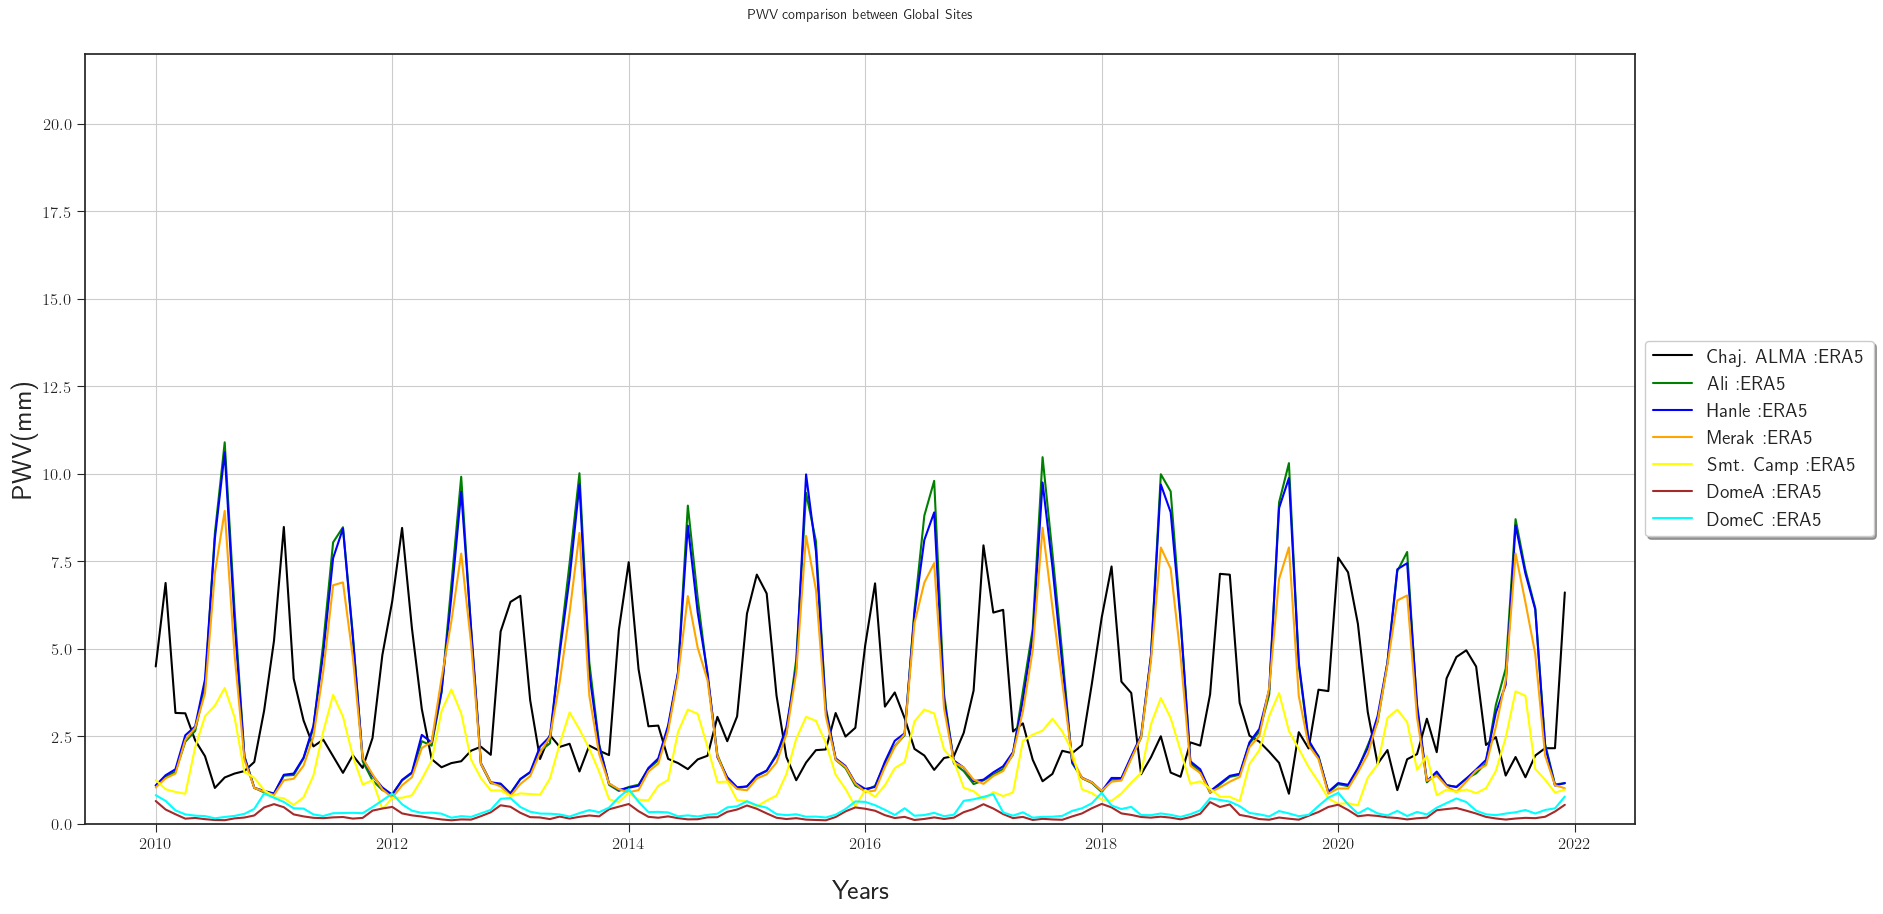

In [41]:
plt.figure(figsize = (25,10))

plt.grid(True)
for i in range(len(sites)):
    if(i==5):
        continue
    else:
        plot_for_loc(sites[i],lat_sites[i],lon_sites[i],lats,lons,yearly_data,lats_merra,lons_merra,yearly_data_merra,markers[i],color[i],start_year = 2010,end_year = 2021)
plt.xticks(size='large')
plt.yticks(size='large')
plt.xlabel("Years",size=20,font ='serif',labelpad=20)
plt.ylabel("PWV(mm)",size=20,font ='serif')
plt.ylim(0,22)
plt.title("PWV comparison between Global Sites",size = 30,pad=25,font ='Courier New',fontweight='bold',)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc = 'center left',bbox_to_anchor=(1,0.5),fancybox=True,frameon = True,shadow=True,fontsize = 14,)
#plt.savefig("NEW Graphs/comparison1.jpeg",dpi=600)
plt.show()


In [19]:
yearly_data.size

523272960

In [20]:
yearly_data.shape

(42, 12, 721, 1440)

In [21]:
np.percentile(yearly_data[:,0,0,0],75)

2.3063522577285767

In [22]:
def get_quantiles(lat,lon,lats,lons,data,quantile):
    data_quantile = []
    lat_idx = find_nearest(lats,lat)
    lon_idx = find_nearest(lons,lon)
    for i in range(12):
        data_quantile.append([i+1,round(np.percentile(data[:,i,lat_idx,lon_idx],quantile),2)])
    return np.array(data_quantile)

In [20]:
def overall_quantiles(data,lat,lon,quantile):
    lat_idx = find_nearest(lats,lat)
    #print(lat,lat_idx)
    lon_idx = find_nearest(lons,lon)
    
    
    data_quantile = round(np.percentile(data[:,:,lat_idx,lon_idx],quantile),5)
    #print(data_quantile)
    return data_quantile

In [21]:
q25_arr = []
q50_arr = []
q75_arr = []
for i in range(len(sites)):
    q25 = overall_quantiles(yearly_data,lat_sites[i],lon_sites[i],25)
    q50 = overall_quantiles(yearly_data,lat_sites[i],lon_sites[i],50)
    q75 = overall_quantiles(yearly_data,lat_sites[i],lon_sites[i],75)
    q25_arr.append(q25)
    q50_arr.append(q50)
    q75_arr.append(q75)

# df =pd.DataFrame([elevation,q25_arr,q50_arr,q75_arr],index= ['Elevation (m)','Q1:25%','Q2:50%','Q3:75%'],columns=sites)
# df.to_excel("PWV_Quantiles_Overall.xlsx")

In [23]:
df_in = pd.read_excel(r"D:\OneDrive - IIT Delhi\Intern\RRI\Indian_Sites.xlsx")
lat_sites_in = (np.array(df_in['lat']))
lon_sites_in = (np.array(df_in['lon']))
sites_in = (np.array(df_in['Site Name']))
elevation_in = (np.array(df_in['Elevation']))

In [23]:
df_in

,Site Name,Elevation,lat,lon
0,Site A,5333,35.24,78.01
1,Site B,5542,34.51,78.51


In [107]:
q25_indian_arr = []
q50_indian_arr = []
q75_indian_arr = []
for i in range(len(sites_in)):
    
    q25_indian  = overall_quantiles(yearly_data,lat_sites_in[i],lon_sites_in[i],25)
    
    q75_indian = overall_quantiles(yearly_data,lat_sites_in[i],lon_sites_in[i],75)
    
    q50_indian = overall_quantiles(yearly_data,lat_sites_in[i],lon_sites_in[i],50)
    

  
   
    q25_indian_arr.append(q25_indian)
    q50_indian_arr.append(q50_indian)
    q75_indian_arr.append(q75_indian)
df_in = pd.DataFrame([elevation_in,q25_indian_arr,q50_indian_arr,q75_indian_arr],index= ['Elevation (m)','Q1:25%','Q2:50%','Q3:75%'],columns=sites_in)
df_in.to_excel("PWV_Quantiles_Indian.xlsx")

In [23]:
for i in range(len(sites_in)):
    q25_in = get_quantiles(lat_sites_in[i],lon_sites_in[i],lats,lons,yearly_data,quantile = 25)
    q50_in = get_quantiles(lat_sites_in[i],lon_sites_in[i],lats,lons,yearly_data,quantile = 50)
    q75_in = get_quantiles(lat_sites_in[i],lon_sites_in[i],lats,lons,yearly_data,quantile = 75)
    df = pd.DataFrame([q25_in[:,1],q50_in[:,1],q75_in[:,1]],index= ['Q1:25%','Q2:50%','Q3:75%'],columns =['January','February','March','April','May','June','July','August','September','October','November','December'])
    df.to_excel("Quartile Data\PWV_Quantiles_{name}.xlsx".format(name = sites_in[i]))

In [37]:
for i in range(len(sites)):
    q25 = get_quantiles(lat_sites[i],lon_sites[i],lats,lons,yearly_data,quantile = 25)
    q50 = get_quantiles(lat_sites[i],lon_sites[i],lats,lons,yearly_data,quantile = 50)
    q75 = get_quantiles(lat_sites[i],lon_sites[i],lats,lons,yearly_data,quantile = 75)
    df = pd.DataFrame([q25[:,1],q50[:,1],q75[:,1]],index= ['Q1:25%','Q2:50%','Q3:75%'],columns =['January','February','March','April','May','June','July','August','September','October','November','December'])
    df.to_excel("Quartile Data\PWV_Quantiles_{name}.xlsx".format(name = sites[i]))

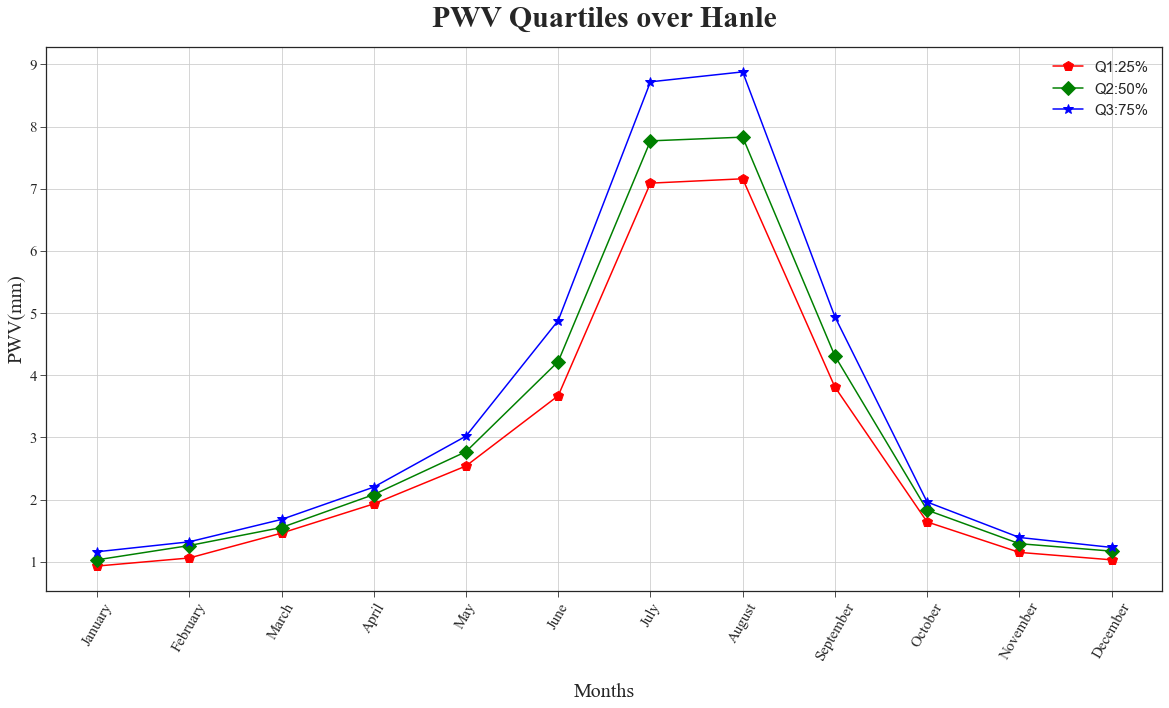

In [109]:
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']
plt.style.use('seaborn-ticks')
plt.figure(figsize = (20,10))
q25 = get_quantiles(32.7,78.96,lats,lons,yearly_data,quantile = 25)
q50 = get_quantiles(32.7,78.96,lats,lons,yearly_data,quantile = 50)
q75 = get_quantiles(32.7,78.96,lats,lons,yearly_data,quantile = 75)
plt.plot(Months,q25[:,1],marker = 'p',markersize = 10,color = 'red',label = 'Q1:25%')
plt.plot(Months,q50[:,1],marker = 'D',markersize = 10,color = 'green',label = 'Q2:50%')
plt.plot(Months,q75[:,1],marker ='*',markersize = 10,color = 'blue',label = 'Q3:75%')
plt.title("PWV Quartiles over Hanle",size = 30,pad=20,font ='Times New Roman',fontweight='bold')
plt.legend(loc = 'best',fontsize = 15,fancybox=True,shadow=True)
plt.xlabel("Months",size=20,font ='Times New Roman',labelpad=20)
plt.ylabel("PWV(mm)",size=20,font ='Times New Roman')
plt.xticks(rotation=60,font ='Times New Roman',size = 15)
plt.yticks(font = 'Times New Roman',size = 15)
plt.grid(True)
#plt.savefig("PWV_Quantiles_Hanle.jpeg",dpi=600)
plt.show()



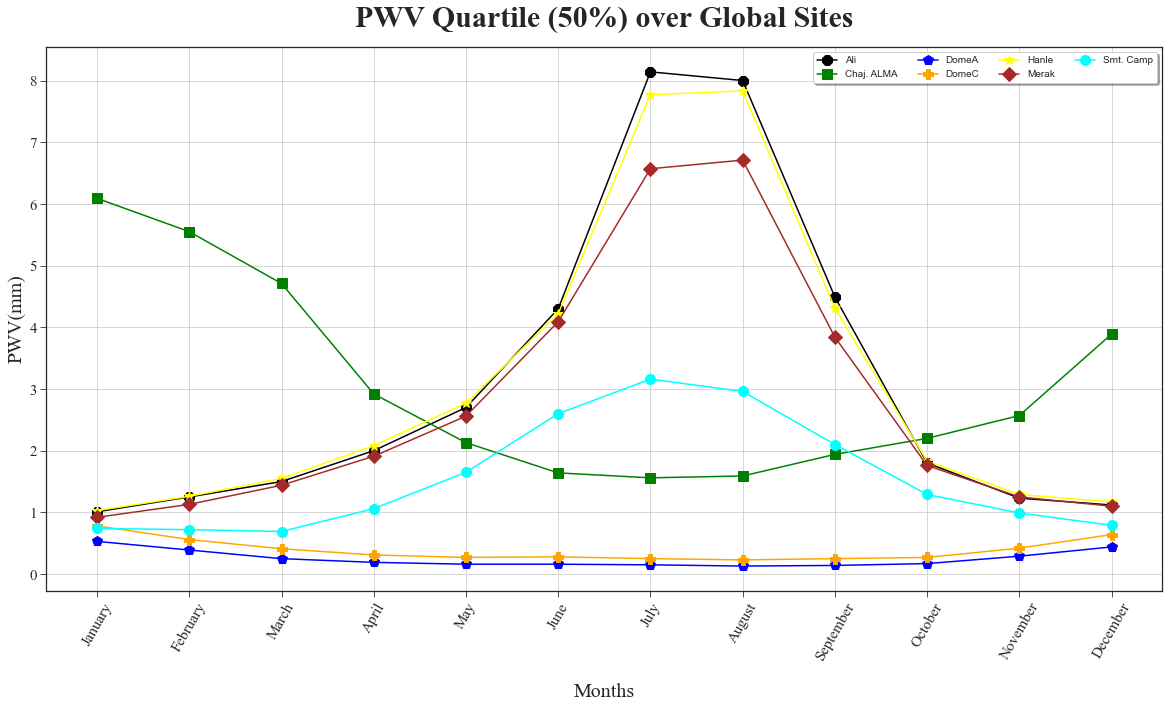

In [69]:
files = glob.glob(r"Quartile Data\*.xlsx")
plt.figure(figsize = (20,10))
for i in range(len(files)):
    name = Path(files[i]).stem
    name = name.split('_')[-1]
    df = pd.read_excel(files[i])
    df.set_index('Unnamed: 0',inplace = True)
    #print(type(df.loc['Q1:25%']))
    if(i==5):
        continue
    else:
        plt.plot(Months,df.loc['Q2:50%'],marker = markers[i],markersize = 10,color = color[i],label = '{name}'.format(name = name))


plt.title("PWV Quartile (50%) over Global Sites",size = 30,pad=20,font ='Times New Roman',fontweight='bold')
plt.legend(loc = 'best',ncol = 4,fontsize = 10,fancybox=True,shadow=True,frameon = True)
plt.xlabel("Months",size=20,font ='Times New Roman',labelpad=20)
plt.ylabel("PWV(mm)",size=20,font ='Times New Roman')
plt.xticks(rotation=60,font ='Times New Roman',size = 15)
plt.yticks(font = 'Times New Roman',size = 15)
plt.grid(True)
# plt.ylim(0,14)
plt.savefig("PWV_Quartile_50%_Global.jpeg",dpi=600)
plt.show()



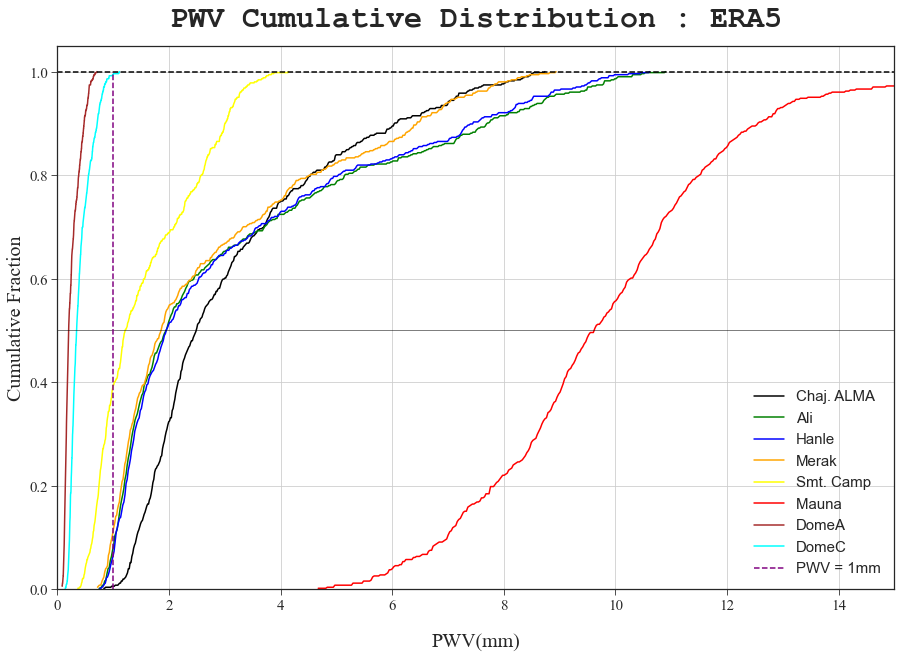

In [32]:
plt.style.use('seaborn-ticks')
# sns.set_style('ticks')
plt.figure(figsize = (15,10))
for i in range(len(sites)):
    pwv_detail = fetch_pwv_details(lat_sites[i],lon_sites[i],lats,lons,yearly_data)
    pwv_detail = pwv_detail.reshape(504)
    count,bins_count = np.histogram(pwv_detail,bins = 504)
    pdf = count/sum(count)
    cdf = np.cumsum(pdf)
    #plt.plot(bins_count[1:],pdf,marker = 'o',markersize = 10,color = 'red',label = 'PDF')
    plt.plot(bins_count[1:],cdf,color = color[i],label = sites[i])


plt.title("PWV Cumulative Distribution : ERA5",size = 30,pad=20,font ='Courier New',fontweight='bold')
plt.hlines(y=1,xmin=0,xmax=15,color = 'black',linestyle = 'dashed')
plt.hlines(y=0.5,xmin=0,xmax=15,color = 'black',linestyle = 'solid',linewidth = 0.5)
plt.vlines(x=1,ymin=0,ymax=1,color = 'purple',linestyle = 'dashed',label='PWV = 1mm')
plt.legend(loc = 'best',fontsize = 15,fancybox=True,shadow=True)
plt.xlabel("PWV(mm)",size=20,font ='Times New Roman',labelpad=20)
plt.ylabel("Cumulative Fraction",size=20,font ='Times New Roman')
plt.xticks(font ='Times New Roman',size = 15,)
plt.yticks(font = 'Times New Roman',size = 15)

plt.ylim(0,1.05)
plt.grid(True)
plt.xlim(0,15)
#plt.ylim(0,1.5)
plt.savefig("PWV_Cumulative_Distribution_Global_ERA5.jpeg",dpi=600)
plt.show()


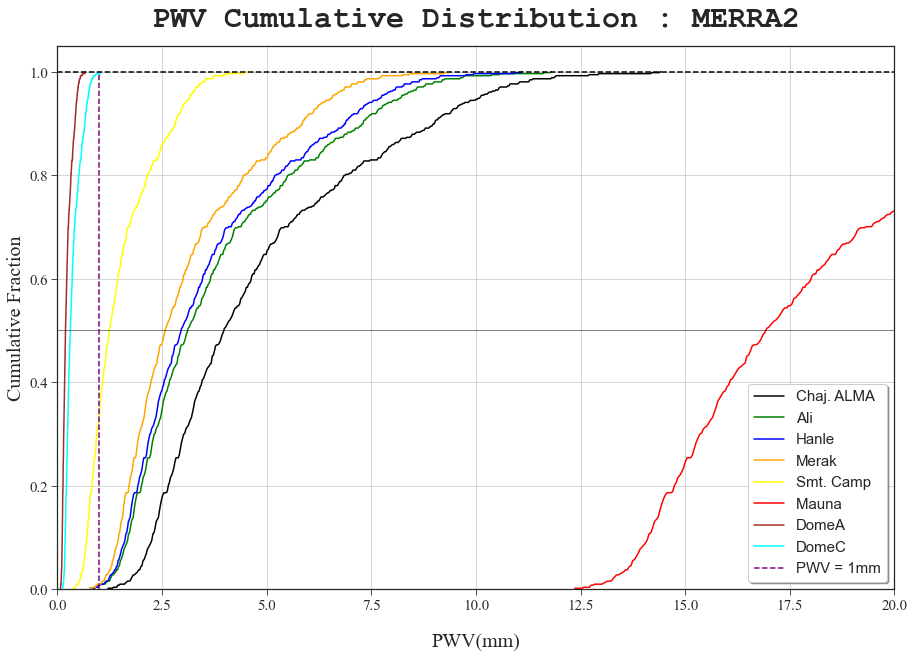

In [31]:
plt.style.use('seaborn-ticks')
# sns.set_style('ticks')
plt.figure(figsize = (15,10))
for i in range(len(sites)):
    if(lon_sites[i] > 180):
        lon_site_new = lon_sites[i] - 360
    else:
        lon_site_new = lon_sites[i]

    pwv_detail_merra = fetch_pwv_details(lat_sites[i],lon_site_new,lats_merra,lons_merra,yearly_data_merra)
    pwv_detail_merra = pwv_detail_merra.reshape(504)
    count_merra,bins_count_merra = np.histogram(pwv_detail_merra,bins = 504)
    pdf_merra = count/sum(count_merra)
    cdf_merra = np.cumsum(pdf_merra)
    #plt.plot(bins_count[1:],pdf,marker = 'o',markersize = 10,color = 'red',label = 'PDF')  
   
    plt.plot(bins_count_merra[1:],cdf_merra,color = color[i],label = sites[i])


plt.title("PWV Cumulative Distribution : MERRA2",size = 30,pad=20,font ='Courier New',fontweight='bold')
plt.hlines(y=1,xmin=0,xmax=20,color = 'black',linestyle = 'dashed')
plt.hlines(y=0.5,xmin=0,xmax=20,color = 'black',linestyle = 'solid',linewidth = 0.5)
plt.vlines(x=1,ymin=0,ymax=1,color = 'purple',linestyle = 'dashed',label='PWV = 1mm')

plt.xlabel("PWV(mm)",size=20,font ='Times New Roman',labelpad=20)
plt.ylabel("Cumulative Fraction",size=20,font ='Times New Roman')
plt.xticks(font ='Times New Roman',size = 15,)
plt.yticks(font = 'Times New Roman',size = 15)

plt.ylim(0,1.05)
plt.grid(True)
plt.xlim(0,20)
#plt.ylim(0,1.5)
plt.legend(loc = 'lower right',fontsize = 15,fancybox=True,shadow=True,frameon = True)
plt.savefig("PWV_Cumulative_Distribution_Global_MERRA2.jpeg",dpi=600)
plt.show()


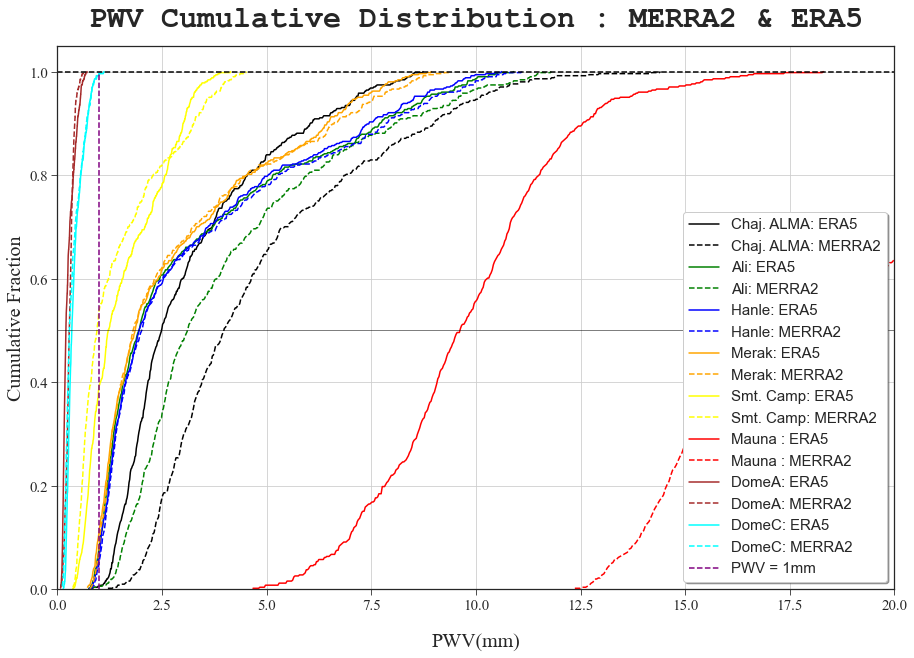

In [30]:
plt.style.use('seaborn-ticks')
# sns.set_style('ticks')
plt.figure(figsize = (15,10))
for i in range(len(sites)):
    if(lon_sites[i] > 180):
        lon_site_new = lon_sites[i] - 360
    else:
        lon_site_new = lon_sites[i]

    pwv_detail_merra = fetch_pwv_details(lat_sites[i],lon_site_new,lats_merra,lons_merra,yearly_data_merra)
    pwv_detail_merra = pwv_detail_merra.reshape(504)
    count_merra,bins_count_merra = np.histogram(pwv_detail_merra,bins = 504)
    pdf_merra = count/sum(count_merra)
    cdf_merra = np.cumsum(pdf_merra)
    #plt.plot(bins_count[1:],pdf,marker = 'o',markersize = 10,color = 'red',label = 'PDF')  
    pwv_detail = fetch_pwv_details(lat_sites[i],lon_sites[i],lats,lons,yearly_data)
    pwv_detail = pwv_detail.reshape(504)
    count,bins_count = np.histogram(pwv_detail,bins = 504)
    pdf = count/sum(count)
    cdf = np.cumsum(pdf)
    #plt.plot(bins_count[1:],pdf,marker = 'o',markersize = 10,color = 'red',label = 'PDF')
    plt.plot(bins_count[1:],cdf,color = color[i],label = sites[i]+': ERA5')

    plt.plot(bins_count_merra[1:],cdf_merra,color = color[i],label = sites[i]+': MERRA2',linestyle= 'dashed')


plt.title("PWV Cumulative Distribution : MERRA2 & ERA5",size = 30,pad=20,font ='Courier New',fontweight='bold')
plt.hlines(y=1,xmin=0,xmax=20,color = 'black',linestyle = 'dashed')
plt.hlines(y=0.5,xmin=0,xmax=20,color = 'black',linestyle = 'solid',linewidth = 0.5)
plt.vlines(x=1,ymin=0,ymax=1,color = 'purple',linestyle = 'dashed',label='PWV = 1mm')

plt.xlabel("PWV(mm)",size=20,font ='Times New Roman',labelpad=20)
plt.ylabel("Cumulative Fraction",size=20,font ='Times New Roman')
plt.xticks(font ='Times New Roman',size = 15,)
plt.yticks(font = 'Times New Roman',size = 15)

plt.ylim(0,1.05)
plt.grid(True)
plt.xlim(0,20)
#plt.ylim(0,1.5)
plt.legend(loc = 'lower right',fontsize = 15,fancybox=True,shadow=True,frameon = True)
plt.savefig("PWV_Cumulative_Distribution_Global_MERRA2_ERA5.jpeg",dpi=600)
plt.show()


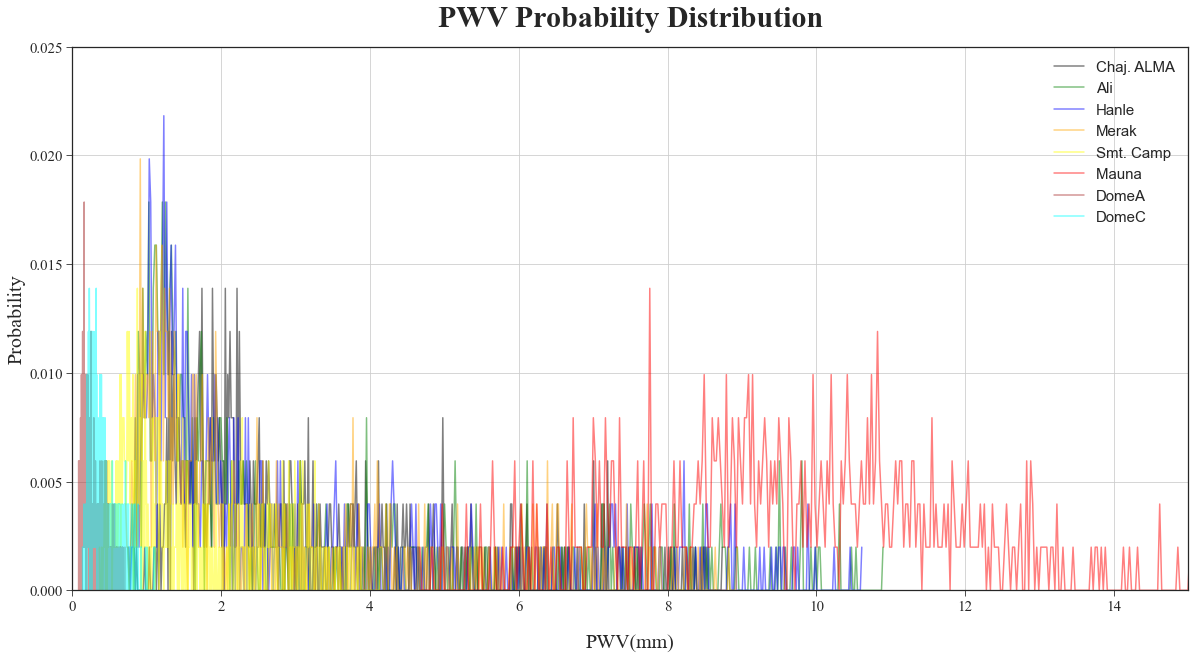

In [120]:
plt.figure(figsize = (20,10))
for i in range(len(sites)):
    pwv_detail = fetch_pwv_details(lat_sites[i],lon_sites[i],lats,lons,yearly_data)
    pwv_detail = pwv_detail.reshape(504)
    count,bins_count = np.histogram(pwv_detail,bins = 504)
    pdf = count/sum(count)
    cdf = np.cumsum(pdf)
    #plt.plot(bins_count[1:],pdf,marker = 'o',markersize = 10,color = 'red',label = 'PDF')
    plt.plot(bins_count[1:],pdf,color = color[i],label = sites[i],alpha = 0.5)


plt.title("PWV Probability Distribution",size = 30,pad=20,font ='Times New Roman',fontweight='bold')

plt.legend(loc = 'best',fontsize = 15,fancybox=True,shadow=True)
plt.xlabel("PWV(mm)",size=20,font ='Times New Roman',labelpad=20)
plt.ylabel("Probability",size=20,font ='Times New Roman')
plt.xticks(font ='Times New Roman',size = 15,)
plt.yticks(font = 'Times New Roman',size = 15)

#plt.ylim(0,1.2)
plt.grid(True)
plt.xlim(0,15)
plt.ylim(0,0.025)
plt.savefig("PWV_Probability_Distribution_Global.jpeg",dpi=600)
plt.show()


MERRA 2

In [24]:
files=glob.glob(r"D:\OneDrive - IIT Delhi\Intern\RRI\New Region\Data\*.nc")

arr_merra = []
for file in files:
    ds = xr.open_dataset(file,decode_cf=True)
    arr_merra.append(ds)
    

In [25]:
fh_merra = xr.concat(arr_merra,dim = 'time')

In [26]:
lons_merra = np.array(fh_merra.variables['lon'][:])
lats_merra = np.array(fh_merra.variables['lat'][:])

time_merra = np.array(fh_merra.variables['time'][:])

i=0
yearly_data_merra = []

while(i<504):
    pwv_slice_merra = fh_merra['TQV'][i:i+12]
    yearly_data_merra.append(np.array(pwv_slice_merra))

    i+=12
yearly_data_merra = np.array(yearly_data_merra)

In [27]:
print(yearly_data_merra.shape)
yearly_data_merra_copy = yearly_data_merra.copy()
# print(yearly_data_merra_copy.shape)
# yearly_data_merra_copy = np.reshape(yearly_data_merra_copy,(504,361,576))
# print(yearly_data_merra_copy.shape)

(42, 12, 361, 576)


Interpolation MERRA2

In [28]:
import scipy.ndimage as ndimage

intp_frame =ndimage.zoom(yearly_data_merra_copy[:,:,:,:],(1,1,721/361,2.5),order = 1)

print(intp_frame.shape)

(42, 12, 721, 1440)


In [29]:
yearly_data_merra_original = yearly_data_merra.copy()
yearly_data_merra = intp_frame

In [30]:
yearly_data_merra.shape

(42, 12, 721, 1440)

In [31]:
lons_merra_original = lons_merra
lons_merra = np.linspace(-180,180,1441)
for i in range(len(lons_merra)):
    
        lons_merra[i] = round(lons_merra[i],2)
#lons_merra = lons_merra[0:1440]
print(lons_merra.shape)

lats_merra_original = lats_merra
lats_merra = np.linspace(-90,90,721)
for j in range(len(lats_merra)):
        lats_merra[j] = round(lats_merra[j],2)

print(lats_merra.shape)


(1441,)
(721,)


In [32]:
lons_merra

array([-180.  , -179.75, -179.5 , ...,  179.5 ,  179.75,  180.  ])

In [33]:

print(yearly_data.shape)
print(yearly_data_merra.shape)

(42, 12, 721, 1440)
(42, 12, 721, 1440)


C:\Users\Tanmay Singh\AppData\Local\Temp\ipykernel_17444\1057042162.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


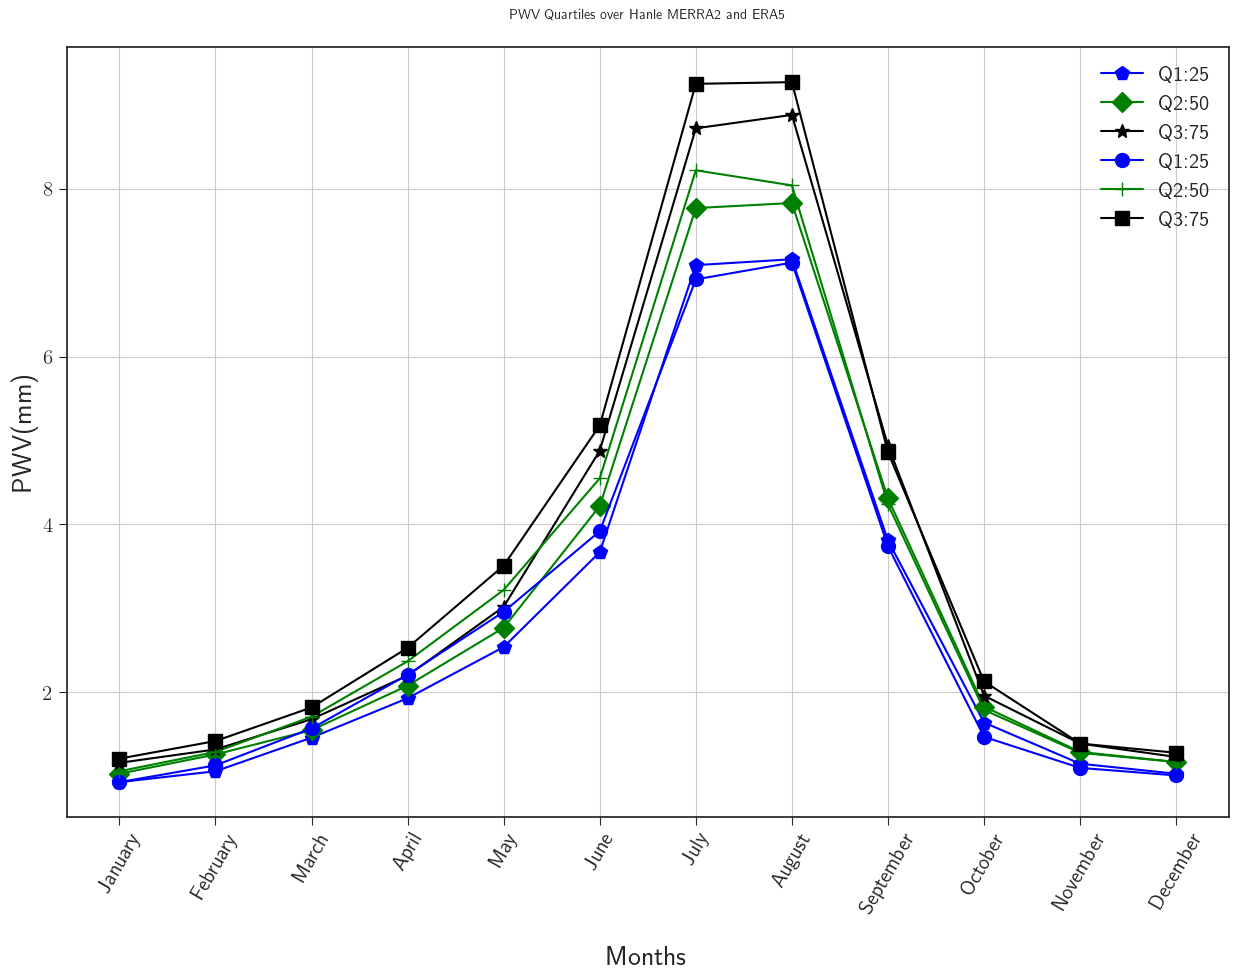

In [34]:
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']
plt.style.use('seaborn-ticks')
plt.figure(figsize = (15,10))
q25_era = get_quantiles(32.7,78.96,lats,lons,yearly_data,25)
q50_era = get_quantiles(32.7,78.96,lats,lons,yearly_data,50)
q75_era = get_quantiles(32.7,78.96,lats,lons,yearly_data,75)
q25_merra = get_quantiles(32.7,78.96,lats_merra,lons_merra,yearly_data_merra,25)
q50_merra = get_quantiles(32.7,78.96,lats_merra,lons_merra,yearly_data_merra,50)
q75_merra = get_quantiles(32.7,78.96,lats_merra,lons_merra,yearly_data_merra,75)

plt.plot(Months,q25_era[:,1],marker = 'p',markersize = 10,color = 'blue',label = 'Q1:25% : ERA5')
plt.plot(Months,q50_era[:,1],marker = 'D',markersize = 10,color = 'green',label = 'Q2:50% :ERA5')
plt.plot(Months,q75_era[:,1],marker ='*',markersize = 10,color = 'black',label = 'Q3:75% : ERA5')
plt.plot(Months,q25_merra[:,1],marker = 'o',markersize = 10,color = 'blue',label = 'Q1:25% : MERRA2')
plt.plot(Months,q50_merra[:,1],marker = '+',markersize = 10,color = 'green',label = 'Q2:50% : MERRA2')
plt.plot(Months,q75_merra[:,1],marker ='s',markersize = 10,color = 'black',label = 'Q3:75% : MERRA2')

plt.title("PWV Quartiles over Hanle MERRA2 and ERA5",size = 30,pad=20,font ='Courier New',fontweight='bold')
plt.legend(loc = 'best',fontsize = 15,fancybox=True,shadow=True)
plt.xlabel("Months",size=20,font ='Times New Roman',labelpad=20)
plt.ylabel("PWV(mm)",size=20,font ='Times New Roman')
plt.xticks(rotation=60,font ='Times New Roman',size = 15)
plt.yticks(font = 'Times New Roman',size = 15)
plt.grid(True)
#plt.savefig("PWV_Quantiles_Hanle_ERA_MERRA.jpeg",dpi=600)
plt.show()

In [22]:
def get_correlation(lat,lon):
    merra2 = fetch_pwv_details(lat = lat,lon = lon,lats_array = lats_merra,lons_array = lons_merra,data = yearly_data_merra)
    
    merra2 = merra2.reshape(504)
    
    if(lon>=0):
        lon = lon
    elif(lon<0):
        lon = lon+360
    era5 = fetch_pwv_details(lat = lat,lon = lon,lats_array = lats,lons_array = lons,data = yearly_data)
    era5 = era5.reshape(504)
    pearson = np.corrcoef(merra2,era5)
    return pearson[0][1]

In [23]:
pearson_data = []
for lat in range(-180,181,1):
    for lon in range(-360,360,1):
    
        pearson = get_correlation(lat/2,lon/2)
        pearson_data.append([lat/2,lon/2,pearson])
pearson_data = np.array(pearson_data)

pearson_data = pearson_data.reshape(361,720,3)
print(pearson_data.shape)
# pearson_data_lon_lat = pearson_data[:,:,0:2]

(361, 720, 3)


In [105]:
print(np.unravel_index(pearson_data[:,:,2].argmin(),pearson_data[:,:,2].shape))

(190, 209)


[  5.         -75.5          0.54789993]


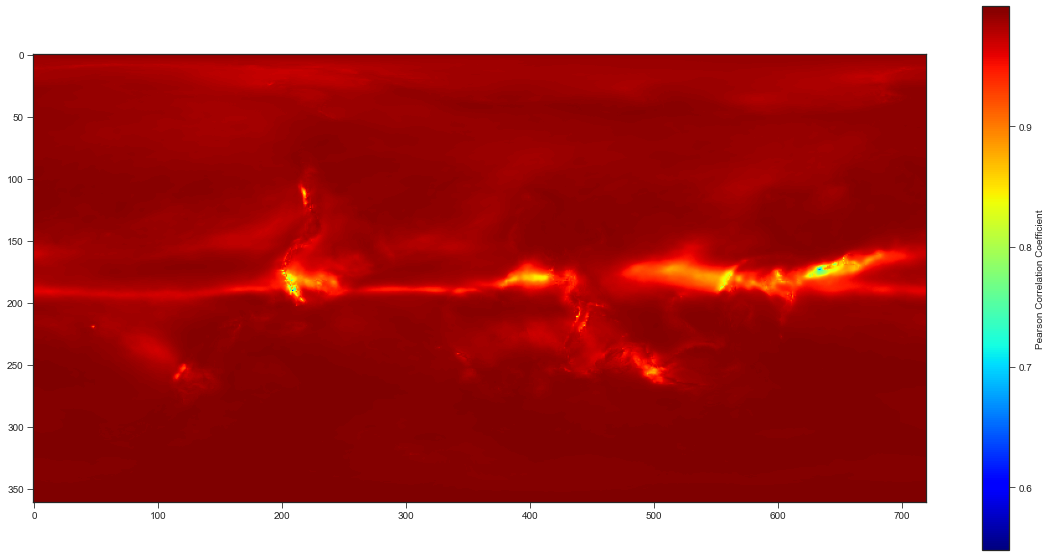

In [106]:
plt.figure(figsize=(20,10))
plt.style.use('seaborn-ticks')
plt.imshow(pearson_data[:,:,2],cmap = 'jet',)
plt.colorbar(label = 'Pearson Correlation Coefficient')
#plt.plot(374,95,marker = 'o',color= 'black')
#plt.plot(190,140,marker = 'o',color= 'black')
#print(pearson_data[95,374,:])
print(pearson_data[190,209,:])



In [307]:
# plt.figure(figsize=(10,10))
# plt.plot(lons_merra,pearson_data[94,:,2])
# plt.figure(figsize=(10,10))
# plt.plot(lats_merra,pearson_data[:,374,2])


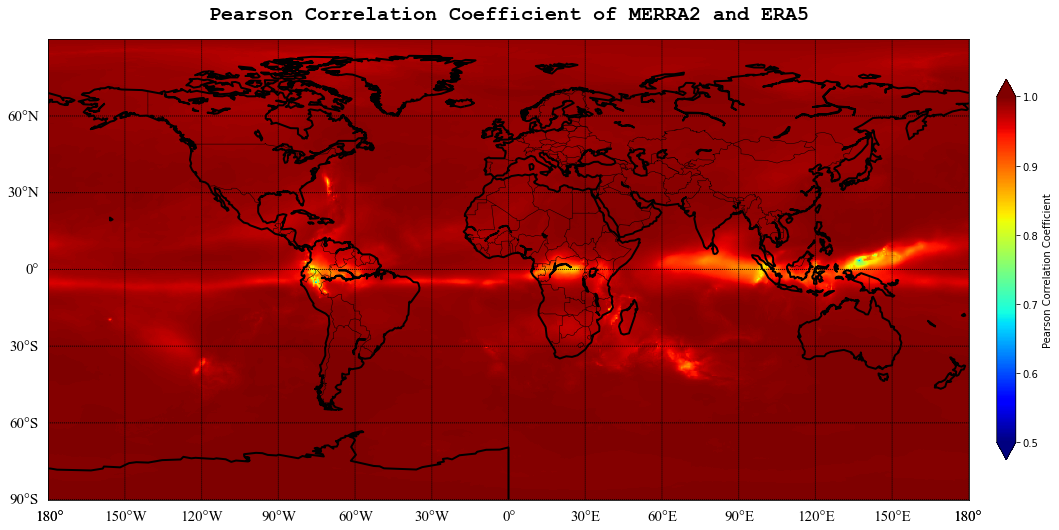

In [27]:
plt.figure(figsize = (20,10))
m= Basemap(projection='cyl',lon_0=0,llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c')
plt.imshow(pearson_data[:,:,2],cmap = 'jet',extent = [-180,180,-90,90])
m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=2)
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0],fontsize=15,font = 'Times New Roman')
m.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,1],fontsize=15,font = 'Times New Roman')
plt.colorbar(cmap = 'jet',label = 'Pearson Correlation Coefficient',extend = 'both',orientation = 'vertical',pad = 0.025,shrink = 0.7)
plt.clim(0.5,1)
#plt.plot(-160,-4,'o',color = 'black',markersize = 10)
plt.title("Pearson Correlation Coefficient of MERRA2 and ERA5",size = 20,pad=20,font ='Courier New',fontweight='bold')
plt.savefig('PWV_Correlation_MERRA_ERA_Other_Lim.jpeg',dpi = 600)
plt.show()

In [71]:
print(pearson_data[184,190,:])
print(get_correlation(0,-135))
print(get_correlation(19.82,-115.47))

[  2.         -85.           0.95660201]
0.9895840703574446
0.995668817032634


In [141]:
df = pd.DataFrame(pearson_data[:,:,2])

In [30]:
def plot_pearson_for_loc_density_map(lat,lon,start_year ,end_year):
    data_merra = fetch_pwv_details(lat = lat, lon = lon,lats_array = lats_merra,lons_array = lons_merra,data = yearly_data_merra,start_year = start_year,end_year = end_year)
    data_merra = data_merra.reshape(end_year-start_year*12)
    if(lon>=0):
        lon = lon
    elif(lon<0):
        lon = lon+360
    data_era = fetch_pwv_details(lat =  lat,lon = lon,lats_array = lats,lons_array = lons,data = yearly_data,start_year = start_year,end_year = end_year)
    data_era = data_era.reshape(end_year-start_year*12)
    linear_fit_data = np.polyfit(data_merra,data_era,1)

    
    MSE = mean_squared_error(data_merra,data_era)
    RMSE = np.sqrt(MSE)

    Samples = len(data_merra)

    pearson = np.corrcoef(data_merra,data_era)

    plt.figure(figsize = (20,10))
    plt.style.use('seaborn-ticks')
    plt.xlim(min(np.min(data_merra),np.min(data_era)),max(np.max(data_merra),np.max(data_era))+2)
    plt.ylim(min(np.min(data_merra),np.min(data_era)),max(np.max(data_merra),np.max(data_era))+2)
    #plt.scatter(data_merra,data_era,marker = 'o',color = 'blue',label = 'MERRA2 and ERA5 over ({x}N,{y}E)'.format(x = lat,y=lon))
    plt.title("PWV Correlation of MERRA2 and ERA5 over ({x}N,{y}E)".format(x = lat,y=lon),size = 30,pad=20,font ='Times New Roman',fontweight='bold')
    plt.plot(data_merra,linear_fit_data[0]*data_merra+linear_fit_data[1],color = 'red',label = 'Linear Fit')

    lims= [
        np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),
        np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),
    ]

    
    plt.plot(lims,lims,color = 'black',label = 'y = x ',linestyle = '--')
    
    density = np.vstack([data_merra,data_era])
    density = gaussian_kde(density)(density)
    density = density/density.min()

    r = pearson[0][1]
    alpha = linear_fit_data[0]
    beta = linear_fit_data[1]

    spearman, p = spearmanr(data_merra,data_era)

    textstr = '\n'.join((
        r'$\beta=%.3f$' % (alpha, ),
        r'$\alpha=%.3f$' % (beta, ),
        r'$R=%.3f$' % (r, ),
        r'$\rho=%.3f$' % (spearman, ),
        r'$RMSE=%.3f$' % (RMSE, ),
        r'$Samples=%.0f$' % (Samples, ),))

    plt.tricontourf(data_merra,data_era,density,cmap='jet',levels=np.linspace(1,int(density.max()),int(density.max())),extend = 'both',)
    plt.colorbar(extend = 'both',label = 'Counts',orientation = 'vertical',pad = 0.025,aspect = 30,)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.03, 0.97, textstr, transform=plt.gca().transAxes,bbox = props,verticalalignment = 'top', color = 'black',fontsize=15,font = 'Times New Roman')
    plt.xticks(font ='Times New Roman',size = 15)
    plt.yticks(font ='Times New Roman',size = 15)
    plt.xlabel("MERRA-2 :PWV(mm)",size=20,font ='Times New Roman',labelpad=20)
    plt.ylabel("ERA5: PWV(mm)",size=20,font ='Times New Roman')
    plt.grid(alpha = 1,linestyle = 'solid')

    plt.legend(loc = 'lower right',fontsize = 15,frameon = True,shadow = True,facecolor = 'white',edgecolor = 'black')
    #plt.savefig('PWV_Correlation_({x}N,{y}E_contour).jpeg'.format(x=lat,y = lon),dpi = 600)
    plt.show()



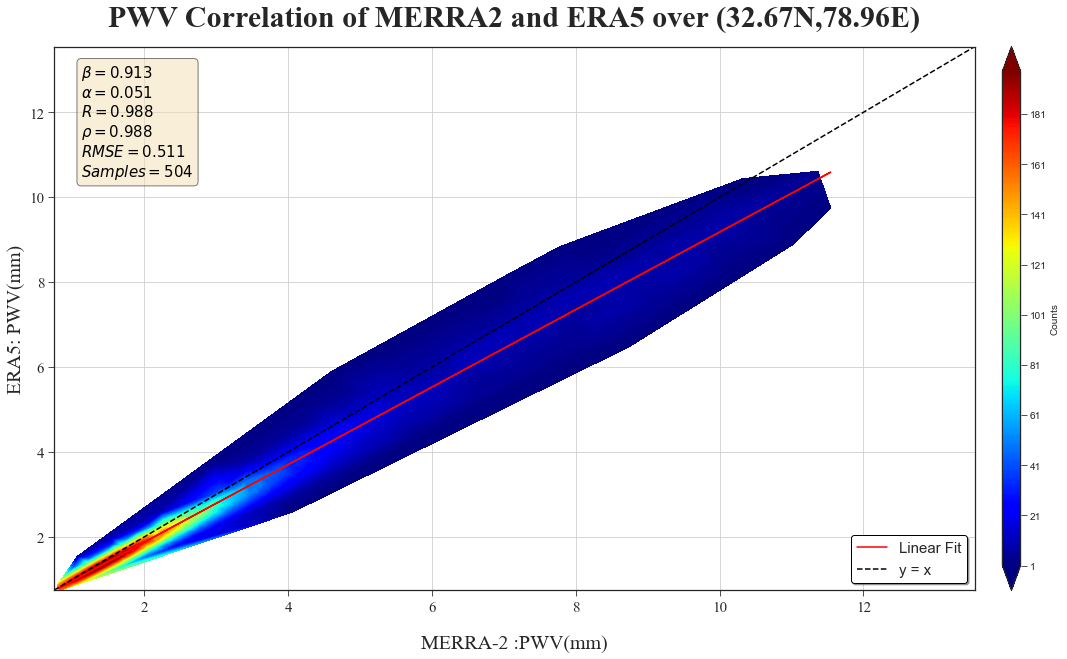

In [101]:
plot_pearson_for_loc_density_map(32.67,78.96,1980,2021)


In [29]:
def plot_pearson_for_loc(lat,lon,start_year ,end_year):
    data_merra = fetch_pwv_details(lat = lat, lon = lon,lats_array = lats_merra,lons_array = lons_merra,data = yearly_data_merra,start_year = start_year,end_year = end_year)
    data_merra = data_merra.reshape(end_year-start_year*12)
    
    if(lon>=0):
        lon = lon
    elif(lon<0):
        lon = lon+360
    data_era = fetch_pwv_details(lat =  lat,lon = lon,lats_array = lats,lons_array = lons,data = yearly_data,start_year = start_year,end_year = end_year)
    data_era = data_era.reshape(end_year-start_year*12)
    linear_fit_data = np.polyfit(data_merra,data_era,1)

    MSE = mean_squared_error(data_merra,data_era)
    RMSE = np.sqrt(MSE)

    Samples = len(data_merra)

    pearson = np.corrcoef(data_merra,data_era)

    plt.figure(figsize = (15,10))
    plt.style.use('seaborn-ticks')
    plt.xlim(min(np.min(data_merra),np.min(data_era)),max(np.max(data_merra),np.max(data_era))+2)
    plt.ylim(min(np.min(data_merra),np.min(data_era)),max(np.max(data_merra),np.max(data_era))+2)
    plt.scatter(data_merra,data_era,marker = 'o',color = 'blue',label = 'MERRA2 and ERA5 over ({x}N,{y}E)'.format(x = lat,y=lon))
    plt.title("PWV Correlation of MERRA2 and ERA5 over ({x}N,{y}E)".format(x = lat,y=lon),size = 20,pad=20,font ='Courier New',fontweight='bold')
    plt.plot(data_merra,linear_fit_data[0]*data_merra+linear_fit_data[1],color = 'red',label = 'Linear Fit')

    lims= [
        np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),
        np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),
    ]

    
    plt.plot(lims,lims,color = 'black',label = 'y = x ',linestyle = '--')

    r = pearson[0][1]
    alpha = linear_fit_data[0]
    beta = linear_fit_data[1]

    spearman, p = spearmanr(data_merra,data_era)

    textstr = '\n'.join((
       
        r'$\beta=%.3f$' % (alpha, ),
        r'$\alpha=%.3f$' % (beta, ),
        r'$R=%.3f$' % (r, ),
        r'$\rho=%.3f$' % (spearman, ),
        r'$RMSE=%.3f$' % (RMSE, ),
        r'$Samples=%.0f$' % (Samples,),))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.03, 0.97, textstr, transform=plt.gca().transAxes,bbox = props,verticalalignment = 'top', color = 'black',fontsize=15,)
    plt.xticks(font ='Times New Roman',size = 15)
    plt.yticks(font ='Times New Roman',size = 15)
    plt.xlabel("MERRA-2 :PWV(mm)",size=20,font ='Times New Roman',labelpad=20)
    plt.ylabel("ERA5: PWV(mm)",size=20,font ='Times New Roman')
    plt.grid(alpha = 1,linestyle = 'solid')

    plt.legend(loc = 'lower right',fontsize = 15,frameon = True,shadow = True,facecolor = 'white',edgecolor = 'black')
    plt.savefig('PWV_Correlation_({x}N,{y}E).jpeg'.format(x=lat,y = lon),dpi = 600,bbox_inches = 'tight')
    plt.show()

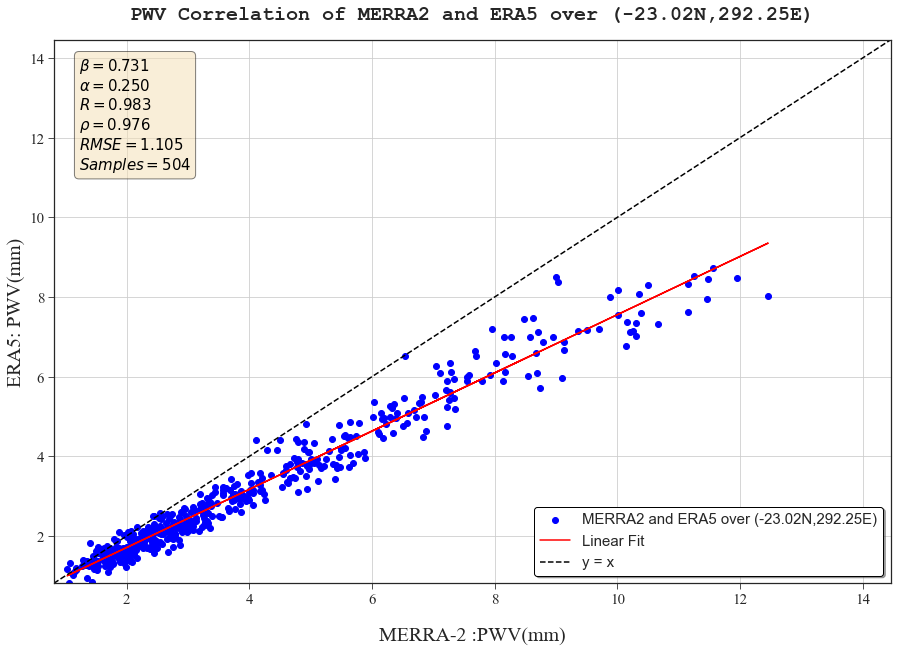

In [31]:
plot_pearson_for_loc(-23.02,-67.75,1980,2021)
#plot_pearson_for_loc(-23.02,-67.76,1980,2021)


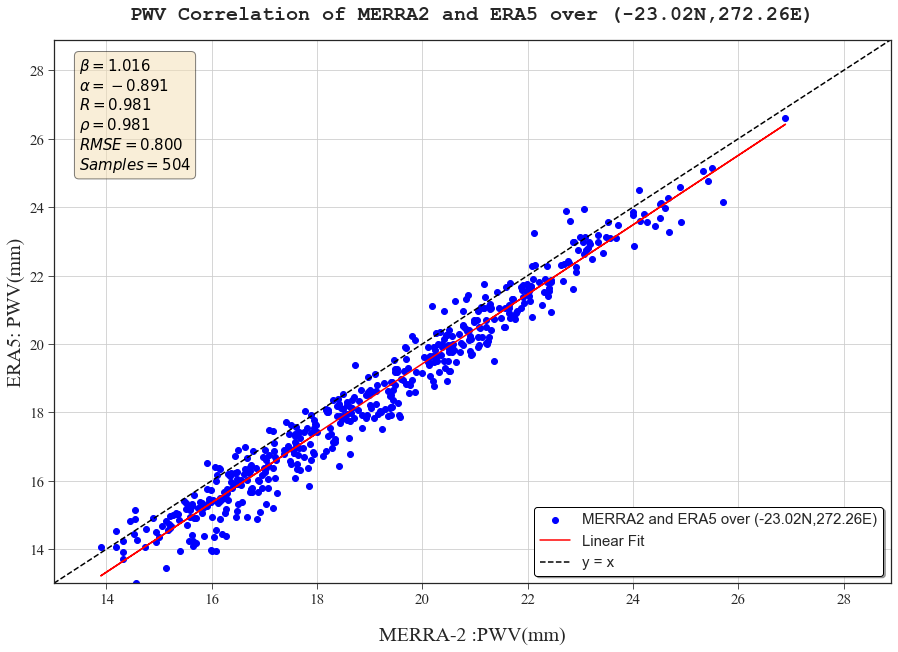

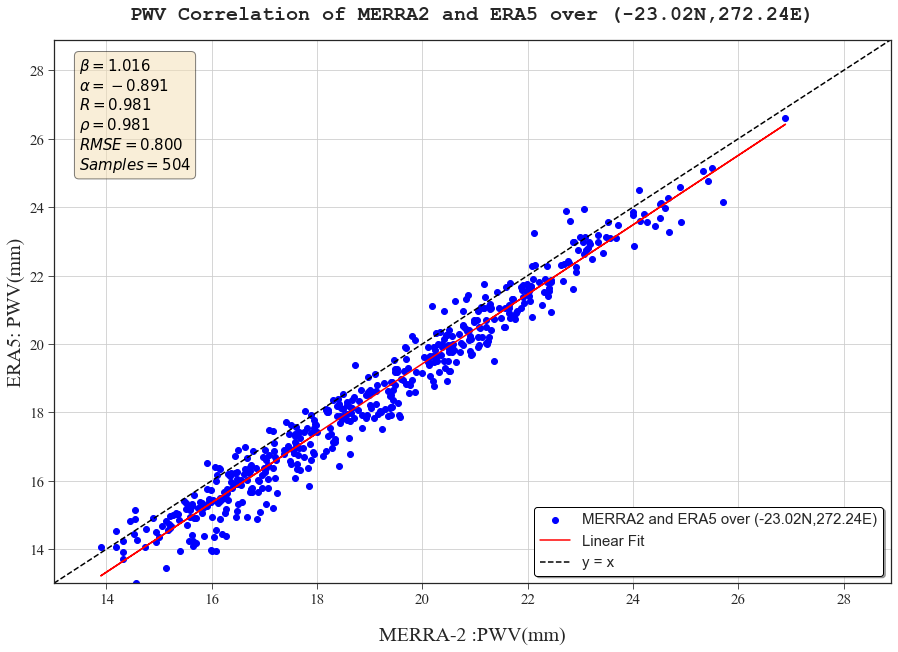

In [109]:
plot_pearson_for_loc(-23.02,-87.74,1980,2021)
plot_pearson_for_loc(-23.02,-87.76,1980,2021)


In [34]:
era = fetch_pwv_details(lat = 32.67,lon = 78.96,lats_array = lats,lons_array = lons,data = yearly_data,start_year = 1998,end_year = 2017)
merra = fetch_pwv_details(lat = 32.67,lon = 78.96,lats_array = lats_merra,lons_array = lons_merra,data = yearly_data_merra,start_year = 1998,end_year = 2017)
era_c = np.median(era,axis = 1)
merra_c = np.median(merra,axis = 1)
print(np.corrcoef(era_c,merra_c))
era,merra  = era.reshape(240),merra.reshape(240)

p = np.corrcoef(era,merra)
print(p)


[[1.         0.53230484]
 [0.53230484 1.        ]]
[[1.         0.98856362]
 [0.98856362 1.        ]]
